### project3_2_eda_modeling.ipynb

This is the notebook where I did my data exploration and cleaning, and ran my first two very simple models, Naive Bayesian and Logistic Regression.

Import libraries:

In [1]:
import pandas as pd
import numpy as np

import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.naive_bayes import BernoulliNB





Read in the data, drop the extra column:

In [2]:
df = pd.read_csv('./data/redditcomments.csv')
df.drop(columns=['Unnamed: 0'],inplace=True)
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20000 entries, 0 to 19999
Data columns (total 3 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   comment  19999 non-null  object
 1   date     20000 non-null  int64 
 2   types    20000 non-null  object
dtypes: int64(1), object(2)
memory usage: 468.9+ KB


Did a little digging and found the null value was in comment #7581, dropped it:

In [3]:
df['comment'][7581]

nan

In [4]:
df.dropna(inplace=True)
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 19999 entries, 0 to 19999
Data columns (total 3 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   comment  19999 non-null  object
 1   date     19999 non-null  int64 
 2   types    19999 non-null  object
dtypes: int64(1), object(2)
memory usage: 625.0+ KB


What kind of comments do I have? First cut, look at the length:

In [5]:
df['char_length'] = [len(comment) for comment in list(df['comment'])]
df.info()


<class 'pandas.core.frame.DataFrame'>
Int64Index: 19999 entries, 0 to 19999
Data columns (total 4 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   comment      19999 non-null  object
 1   date         19999 non-null  int64 
 2   types        19999 non-null  object
 3   char_length  19999 non-null  int64 
dtypes: int64(2), object(2)
memory usage: 781.2+ KB


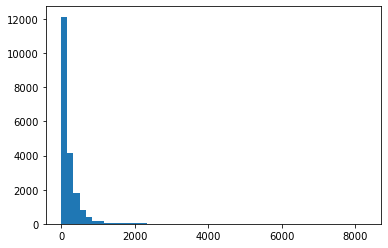

In [6]:
plt.hist(df['char_length'],50);

In [7]:
df['char_length'].min()

1

In [8]:
df['char_length'].max()

8288

In [9]:
df[df['char_length'] == df['char_length'].max()]['comment']


16246     The question of whether we are alone in space...
Name: comment, dtype: object

In [10]:
df['comment'][16246][:1000]

' The question of whether we are alone in space has always sparked the imagination of mankind. But what should we do if we really encounter some form of extraterrestrial intelligence? In his book "You Are There - How First Contact with Aliens Could Change Our Society" (Complete Media 2020), the sociologist Michael Schetsche and his co-author Andreas Anton outline possible scenarios. With his thought experiments, Schetsche wants to establish exosociology - a discipline that deals with the consequences of a human-alien encounter. \n\n&amp;#x200B;\n\n \n\n**Schetch:** Intelligence is relative. We\'ve been arguing for 60 years whether dolphins are intelligent or not. If we receive a signal of extraterrestrial origin, if we find the remains of an extraterrestrial space probe or if a foreign object enters our solar system, no one would doubt that they are intelligent beings simply because of the necessary technical skills. However, if one day in the distant future, most likely millennia in t

In [11]:
df.groupby('types')['char_length'].min()

types
fantasy    1
scifi      1
Name: char_length, dtype: int64

In [12]:
df.groupby('types')['char_length'].max()

types
fantasy    6301
scifi      8288
Name: char_length, dtype: int64

In [13]:
df[df['char_length']==1]['comment'].head()

377     😭
1835    🌻
2130    ?
6226    👍
6256    🙌
Name: comment, dtype: object

In [14]:
df[df['char_length']==2]['comment'].head()

1163    Aa
5240    No
5766    :c
5861    No
7583    🙌🏻
Name: comment, dtype: object

In [15]:
df[df['char_length']==3]['comment'].head()

465     Bl?
2462    Dad
3463    Lol
3680    WoW
5275    yes
Name: comment, dtype: object

So it looks like really short ones are useless in terms of information. I would love to be more restrictive, but I don't want to lose half my data either, so I'm just throwing out comments shorter than 10 characters.

Also there are a few really long ones that are not conversational -- they read like book reports. Not so helpful for my problem statement. So I'm throwing out any comments 1000 characters or longer.

In [16]:
df[(df['char_length']>=10) & (df['char_length']<1000)]['types'].value_counts(normalize=True)

fantasy    0.503787
scifi      0.496213
Name: types, dtype: float64

In [17]:
df[(df['char_length']>=10) & (df['char_length']<1000)]['types'].value_counts(normalize=False)

fantasy    9444
scifi      9302
Name: types, dtype: int64

In [18]:
df = df[(df['char_length']>=10) & (df['char_length']<1000)]
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 18746 entries, 0 to 19999
Data columns (total 4 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   comment      18746 non-null  object
 1   date         18746 non-null  int64 
 2   types        18746 non-null  object
 3   char_length  18746 non-null  int64 
dtypes: int64(2), object(2)
memory usage: 732.3+ KB


Good, I still have a fair amount of data. 

Also did some digging to establish what moderator remove messages look like; they appear to always contain the word "removed". I may remove a few good comments this way, but I am simply dumping any comments with that word.

In [19]:
comments = list(df['comment'])
flagged = [1 if ('removed' in comment.split(' ')) else 0 for comment in comments]
for n, f in enumerate(flagged):
    if f==1: print(comments[n])


Hi there, unfortunately this post has been removed under our Self Promo guidelines. Please consult our rules in the sidebar and feel free to [modmail](https://www.reddit.com/message/compose?to=/r/Fantasy) us if you have any questions.
Hi there! This post has been removed per our Self Promotion and Writing Discussion policies. Please take some time to review the subreddit sidebar for additional information, and feel free to reach out via [modmail](https://www.reddit.com/message/compose?to=%2Fr%2FFantasy) with any follow-up questions. Thank you!
Hi there! This post has been removed as it is not a good fit for this subreddit. We attempt to ensure all posts are dealing directly with published fantasy media such as books, films, graphic novels, etc. Consider a community like r/FindAReddit to assist with finding a more appropriate place to post about this topic. Please take some time to review the subreddit sidebar for additional information, and feel free to reach out via [modmail](https://

In [20]:
comments = list(df['comment'])
df['flagged'] = [1 if ('removed' in comment.split(' ')) else 0 for comment in comments]
df = df[df['flagged']==0]

Set my X (comment text) and y (which subreddit):

In [42]:
X = df['comment']
y = df['types']


I started with just Count Vectorization. Later I went back and tried Tfid instead, but it didn't really help:

In [22]:
cvec = CountVectorizer(stop_words='english')

In [23]:
cvec.fit(X)
X_cv = cvec.transform(X)

EDA: What are the common words?

<AxesSubplot:>

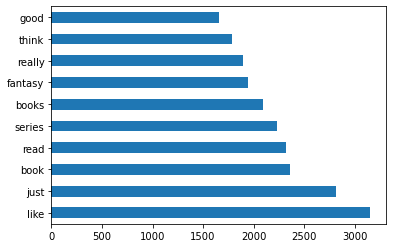

In [24]:
words = pd.DataFrame(X_cv.todense(),columns= cvec.get_feature_names())

# plot top occuring words
words.sum().sort_values(ascending = False).head(10).plot(kind='barh')

I am interested in discerning which words (hopefully referring to specific series or characters) are particularly unique to each genre, fantasy vs. scifi. So I'm going to take some time to ind words that are frequent in both, and remove them:

In [25]:
def plot_common_words(df,subreddit,stop_words):
    
    # Makes a plot of the common words in a given subreddit:
    cv0 = CountVectorizer(stop_words=stop_words)
    X0 = df[df['types']==subreddit]['comment']
    cv0.fit(X0)
    X0_cv = cv0.transform(X0)
    words = pd.DataFrame(X0_cv.todense(),columns= cv0.get_feature_names())
    words.sum().sort_values(ascending = False).head(20).plot(kind='barh');
    plt.title(subreddit);

In [26]:
def compare_sets(df,stop_words,plot=1,num_header=10):
    
    # Compares the top 10/20/num_header words in the two subreddits, and
    # makes a list of the words that are in the top "num_header" list of BOTH (the overlap)
    #
    # if plot = 1, a plot of the most frequent words in each is generated.
    #
    # stop_words is an input. This will be run iteratively, adding words to the stop_words
    # list each time.
    #
    if plot==1: fig, axs = plt.subplots(2,1);
    subreddits = ['fantasy', 'scifi']
    for n,subreddit in enumerate(subreddits):
    #loop over the two subreddits:
    
        # count vectorize using the input stop_words list:
        cv0 = CountVectorizer(stop_words=stop_words)
        # grab just the comments from one subreddit:
        X0 = df[df['types']==subreddit]['comment']
        cv0.fit(X0)
        X0_cv = cv0.transform(X0)
        
        # make a list of most frequent words, and if plot == 1, make the plot:
        words = pd.DataFrame(X0_cv.todense(),columns= cv0.get_feature_names())
        chk = words.sum().sort_values(ascending = False).head(num_header)
        if plot==1: chk.plot(kind='barh',ax=axs[n],legend=False,ylabel=subreddit);
        
        #check for overlap:
        if n==0:
            first_set = list(chk.index)
        else:
            new_set = list(chk.index)
            overlap = [word for word in new_set if word in first_set]
            
    print('Words in both sets:')
    print(overlap)
    return overlap

In [27]:
# initialize CountVectorizer once just to grab the standard "english" stop_words list
cv1 = CountVectorizer(stop_words='english')
stop_eng = list(cv1.get_stop_words())


Words in both sets:
['like', 'just', 'really', 'think', 'don', 'series']


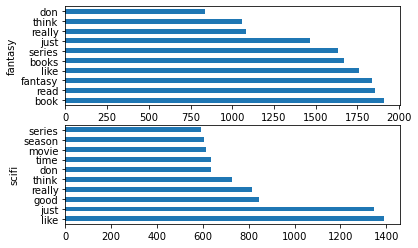

In [28]:
# do an initial comparison:
overlap = compare_sets(df,stop_eng,plot=1,num_header=10)

In [29]:
overlap = compare_sets(df,stop_eng,plot=0,num_header=10)

Words in both sets:
['like', 'just', 'really', 'think', 'don', 'series']


In [30]:
# make my initial stop_words list, which is the "english" list plus the actual subreddit names:
stop_eng = list(cv1.get_stop_words())
stops = stop_eng.copy()
stops += ['fantasy', 'scifi', 'sci', 'fi']
stops

['front',
 'have',
 'two',
 'elsewhere',
 'across',
 'con',
 'further',
 'can',
 'though',
 'an',
 'my',
 'at',
 'please',
 'everything',
 'latterly',
 'show',
 'interest',
 'therein',
 'beside',
 'back',
 'already',
 'when',
 'serious',
 'each',
 'into',
 'twelve',
 'give',
 'ten',
 'find',
 'herself',
 'its',
 'become',
 'might',
 'whom',
 'off',
 'over',
 'will',
 'whether',
 'the',
 'hereafter',
 'anyone',
 'against',
 'on',
 'whereafter',
 'whenever',
 'nowhere',
 'then',
 'own',
 'otherwise',
 'your',
 'myself',
 'mill',
 'together',
 'been',
 'yourselves',
 'nine',
 'another',
 'under',
 'me',
 'thick',
 'cannot',
 'five',
 'hereby',
 'since',
 'ours',
 'several',
 'thence',
 'keep',
 'herein',
 'mostly',
 'until',
 'thru',
 'again',
 'onto',
 'nobody',
 'should',
 'around',
 'inc',
 'very',
 'nor',
 'for',
 'ourselves',
 'where',
 'both',
 'she',
 'everywhere',
 'ie',
 'eleven',
 'meanwhile',
 'could',
 'hers',
 'itself',
 'all',
 'do',
 'must',
 'whoever',
 'how',
 'has',
 'co

iteration #0:
Words in both sets:
['like', 'just', 'good', 'really', 'think', 'don', 'time', 'series', 'people', 'com', 'https', 'read', 'www', 'book', 've']
iteration #1:
Words in both sets:
['great', 'story', 'books', 'way', 'gt', 'know', 'got', 'lot', 'pretty', 'reddit']
iteration #2:
Words in both sets:
['didn', 'character', 'going', 'love', 'll', 'actually', 'say']
iteration #3:
Words in both sets:
['did', 'make', 'years', 'sure', 'world']
iteration #4:
Words in both sets:
['better', 'thing', 'characters', 'want']
iteration #5:
Words in both sets:
['new', 'things', 'doesn']
iteration #6:
Words in both sets:
['yeah', 'right']
iteration #7:
Words in both sets:
['questions']
iteration #8:
Words in both sets:
['maybe']
iteration #9:
Words in both sets:
['thank']
Words in both sets:
[]


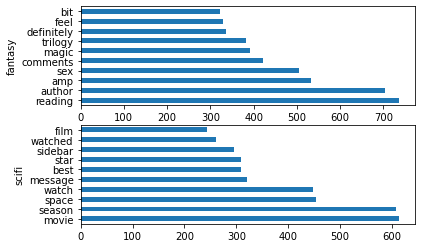

In [31]:
# Iterate 10 times to try to improve the stop list. 
# After each comparison, and overlap in the two "most frequent" lists will be added to stop_words

for i in range(10):
    print(f'iteration #{i}:')
    overlap = compare_sets(df,stops,plot=0,num_header=20)
    stops += overlap

# After the 10 iterations, plot the resulting non-overlapping list of most frequent words:
overlap = compare_sets(df,stops,plot=1,num_header=10)



In [32]:
stops

['front',
 'have',
 'two',
 'elsewhere',
 'across',
 'con',
 'further',
 'can',
 'though',
 'an',
 'my',
 'at',
 'please',
 'everything',
 'latterly',
 'show',
 'interest',
 'therein',
 'beside',
 'back',
 'already',
 'when',
 'serious',
 'each',
 'into',
 'twelve',
 'give',
 'ten',
 'find',
 'herself',
 'its',
 'become',
 'might',
 'whom',
 'off',
 'over',
 'will',
 'whether',
 'the',
 'hereafter',
 'anyone',
 'against',
 'on',
 'whereafter',
 'whenever',
 'nowhere',
 'then',
 'own',
 'otherwise',
 'your',
 'myself',
 'mill',
 'together',
 'been',
 'yourselves',
 'nine',
 'another',
 'under',
 'me',
 'thick',
 'cannot',
 'five',
 'hereby',
 'since',
 'ours',
 'several',
 'thence',
 'keep',
 'herein',
 'mostly',
 'until',
 'thru',
 'again',
 'onto',
 'nobody',
 'should',
 'around',
 'inc',
 'very',
 'nor',
 'for',
 'ourselves',
 'where',
 'both',
 'she',
 'everywhere',
 'ie',
 'eleven',
 'meanwhile',
 'could',
 'hers',
 'itself',
 'all',
 'do',
 'must',
 'whoever',
 'how',
 'has',
 'co

Save the stopwords to a file:

In [33]:
stopwords = pd.DataFrame(stops)
stopwords.to_csv('./data/stopwords.csv')

### Baseline:

In [34]:
# The "NULL" model would just guess all the comments came from one subreddit, so the baseline 
# accuracy is the proportion of whichever subreddit is dominant.

baseline = y.value_counts(normalize=True).max()
baseline

0.5019832761578045

### First try models:

In [49]:
X = df['comment']
y = df['types']

y.value_counts(normalize=True)

fantasy    0.501983
scifi      0.498017
Name: types, dtype: float64

In [50]:
# test train split -- my data is pretty close to a 50/50 balance, but I will stratify just to be safe:
X_train, X_test, y_train, y_test = train_test_split(X,y,random_state = 42, stratify=y)

# Count Vectorize with the NEW stop_words list:
cv = CountVectorizer(stop_words=stops)
cv.fit(X_train,y_train)
X_train = cv.transform(X_train)
X_test  = cv.transform(X_test)


In [51]:
lr = LogisticRegression()
lr.fit(X_train,y_train)
lr_train = lr.score(X_train,y_train)
lr_test  = lr.score(X_test,y_test)
print(f'Train: {lr_train}, Test: {lr_test}')

Train: 0.9505431675242996, Test: 0.8048885077186964


In [52]:
y2 = df['types'].map({'fantasy':0, 'scifi':1})
y2.value_counts(normalize=True)

0    0.501983
1    0.498017
Name: types, dtype: float64

In [54]:
# test train split -- my data is pretty close to a 50/50 balance, but I will stratify just to be safe:
X_train, X_test, y_train2, y_test2 = train_test_split(X,y2,random_state = 42, stratify=y)

# Count Vectorize with the NEW stop_words list:
cv = CountVectorizer(stop_words=stops)
cv.fit(X_train,y_train2)
X_train = cv.transform(X_train)
X_test  = cv.transform(X_test)



In [55]:
lr = LogisticRegression()
lr.fit(X_train,y_train2)
lr_train = lr.score(X_train,y_train2)
lr_test  = lr.score(X_test,y_test2)
print(f'Train: {lr_train}, Test: {lr_test}')

Train: 0.9505431675242996, Test: 0.8048885077186964


So - I didn't actually binarize my y before I did all my modeling. But the scores are unchanged. So it appears that I got lucky and sklearn binarizes it for you.

Check a couple others:

In [56]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier


In [59]:
print('KNN:')
lr = KNeighborsClassifier()
lr.fit(X_train,y_train)
lr_train = lr.score(X_train,y_train)
lr_test  = lr.score(X_test,y_test)
print(f'Train: {lr_train}, Test: {lr_test}')
lr = KNeighborsClassifier()
lr.fit(X_train,y_train2)
lr_train = lr.score(X_train,y_train2)
lr_test  = lr.score(X_test,y_test2)
print(f'Train: {lr_train}, Test: {lr_test}')
print('Random Forest:')
lr = RandomForestClassifier()
lr.fit(X_train,y_train)
lr_train = lr.score(X_train,y_train)
lr_test  = lr.score(X_test,y_test)
print(f'Train: {lr_train}, Test: {lr_test}')
lr = RandomForestClassifier()
lr.fit(X_train,y_train2)
lr_train = lr.score(X_train,y_train2)
lr_test  = lr.score(X_test,y_test2)
print(f'Train: {lr_train}, Test: {lr_test}')
print('SVC:')
lr = SVC()
lr.fit(X_train,y_train)
lr_train = lr.score(X_train,y_train)
lr_test  = lr.score(X_test,y_test)
print(f'Train: {lr_train}, Test: {lr_test}')
lr = SVC()
lr.fit(X_train,y_train2)
lr_train = lr.score(X_train,y_train2)
lr_test  = lr.score(X_test,y_test2)
print(f'Train: {lr_train}, Test: {lr_test}')
print('Decision Tree:')
lr = DecisionTreeClassifier()
lr.fit(X_train,y_train)
lr_train = lr.score(X_train,y_train)
lr_test  = lr.score(X_test,y_test)
print(f'Train: {lr_train}, Test: {lr_test}')
lr = DecisionTreeClassifier()
lr.fit(X_train,y_train2)
lr_train = lr.score(X_train,y_train2)
lr_test  = lr.score(X_test,y_test2)
print(f'Train: {lr_train}, Test: {lr_test}')

KNN:
Train: 0.7627215551743853, Test: 0.6125643224699828
Train: 0.7627215551743853, Test: 0.6125643224699828
Random Forest:
Train: 0.993281875357347, Test: 0.7579331046312179
Train: 0.993281875357347, Test: 0.7607204116638079
SVC:
Train: 0.9173813607775871, Test: 0.7669382504288165
Train: 0.9173813607775871, Test: 0.7669382504288165
Decision Tree:
Train: 0.993281875357347, Test: 0.6974699828473413
Train: 0.993281875357347, Test: 0.7004716981132075


Whew. I was kind of scared there. It seems that sklearn covered my mistake of not turning y into numeric form. Slight differences on the Decision Tree and Random Forest due to inherent randomness, but not significant.